# Problem description / Topic Modelling

We will use a unsupervised machine learning algorithm to categorize Customer Support help center articles - also known as **Topic Modelling**. The problem we are trying to solve is that searching a few hundred help center article has a better user experience when you can use tags to find articles that matter to you. This will also be used for search. 

# Step 1: Gather data


I'll create a function that will download the text from a specific help center that uses Zendesk (A SaaS). We check if the data already exists at `data/articles.csv`, if it does then we don't get the data again. 

Since each help center is related to one specific business, we will only process one companies help center instead of processing many help center. This will allow our Topic Modelling model(s) to be more accurate for each specific business.

In [50]:
import requests
import pandas as pd
import os

def fetch_articles():
    url = "https://support.amboss.com/api/v2/help_center/en-us/articles?per_page=100"
    all_articles = []

    while url:
        response = requests.get(url)
        data = response.json()
        all_articles.extend(data['articles'])
        url = data.get('next_page')

    return all_articles

def save_articles_to_csv(articles, filename):
    df = pd.DataFrame(articles)
    df.to_csv(filename, index=False)

file_path = 'data/articles.csv'

if not os.path.exists(file_path):
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    articles = fetch_articles()
    save_articles_to_csv(articles, file_path)
    print(f"Articles saved to {file_path}")
else:
    print(f"File {file_path} already exists. Skipping data collection.")


File data/articles.csv already exists. Skipping data collection.


# Step 2 - Identify an Unsupervised Learning Problem

For categorizing / labelling a relatively large amount (100+) customer support help center articles, we will use Topic Modelling (and most likely Latent Dirichlet Allocation) as the unsupervised learning algorithm because we don't have labels on the existing customer support help center articles. In addition, we are an external team, so we won't have the knowledge needed to manually label the data. Some other reasons we will use that unsupervised learning algorithm:
* It can discover latent features well within a collection of documents.
* Topic Modelling works well with unstructured text.
* It can handle new and update help center articles well - since the information on a support help center changes often, we want a scalable solution. 
* It is also flexible, and will be able to find latent features in any new informmation that is provided in the help center articles. 
* It can condense the high dimensionaility of words into a lower dimension topics, which will make it easier to analyze the overall themes.

Using a supervised machine learning algorithm is not ideal because we don't have labelled data and we want this solution to be scalable. We want to be able to handle new topics without needing to re-fit or label our data - otherwise a supervised algorithm will be considered overfit if we don't re-train the model when new topics or themes in the support help center are introduced.

# Step 3 - EDA



• Describe the factors or components that make up the dataset (The "factors" here are
called "features" in the machine learning term. These factors are often columns in the
tabulated data). For each factor, use a box-plot, scatter plot, histogram, etc., to
describe the data distribution as appropriate.
• Describe correlations between different factors of the dataset and justify your
assumption that they are correlated or not correlated. You may use numeric or
qualitative/graphical analysis for this step.
• Determine if any data needs to be transformed. For example, if you're planning on
using an SVM method for prediction, you may need to normalize or scale the data if
there is a considerable difference in the range of the data.
• Using your hypothesis, indicate if it's likely that you should transform data, such as
using a log transform or other transformation of the dataset.
• You should determine if your data has outliers or needs to be cleaned in any way.
Are there missing data values for specific factors? How will you handle the data
cleaning? Will you discard, interpolate or otherwise substitute data values?
• If you believe that specific factors will be more important than others in your
analysis, you should mention which and why. You will use this to confirm your
intuitions in your final write-up.

In [51]:
# First, we'll do some basic checking of the data
# things like column shape, column names, some of the first rows, see if there are any missing values

df = pd.read_csv(file_path)


print("Dataset shape:", df.shape)
print(f"Number of articles: {df.shape[0]}")
print("Column names:")
print(df.columns.tolist())
print("First two rows of the dataset:")
print(df[:2])
print("Missing values:")
print([(column, count) for column, count in df.isnull().sum().items() if count > 0])  # only show columns with missing values

Dataset shape: (165, 26)
Number of articles: 165
Column names:
['id', 'url', 'html_url', 'author_id', 'comments_disabled', 'draft', 'promoted', 'position', 'vote_sum', 'vote_count', 'section_id', 'created_at', 'updated_at', 'name', 'title', 'source_locale', 'locale', 'outdated', 'outdated_locales', 'edited_at', 'user_segment_id', 'permission_group_id', 'content_tag_ids', 'label_names', 'body', 'user_segment_ids']
First two rows of the dataset:
               id                                                url  \
0  23699429949841  https://amboss.zendesk.com/api/v2/help_center/...   
1  16195168657809  https://amboss.zendesk.com/api/v2/help_center/...   

                                            html_url     author_id  \
0  https://support.amboss.com/hc/en-us/articles/2...  403291139191   
1  https://support.amboss.com/hc/en-us/articles/1...  380858881411   

   comments_disabled  draft  promoted  position  vote_sum  vote_count  ...  \
0               True  False     False         

Ok cool, we did some basic EDA. Seems like a lot of columns, so the first thing we should do is try to reduce the number of columns as they will be the features of our unsupervised ML model. It also looks like the `body` column has HTML which would not be helpful for a Topic Modelling algorithm. Though it is possible that HTML with higher importance (like an H1 tag vs an H6 tag) could be more important, I think we would need to use a neural network for the model to train on the difference, and an unsupervised algorithm like LDA would not be able to work well with those nuances.

Even though we will probably end up using the LDA algorithm and use a combination of the title and the body features, we should still perform some kind of EDA in case we decide to use different algorithms that will make use of other features. 

So first EDA procedure we will be to remove columns that will provide no value: 
1. Remove unused columns (columns with nan)
2. Remove columns that are only provide an id
3. Remove columns that only have one unique value 


In [52]:
# first, let's count how many columns we are starting with
print(f"Number of columns before cleaning: {len(df.columns)}")

#drop columns with missing values or empty arrays
df = df.dropna(axis=1)

# remove columns that only provide id if they exist
id_columns = ['id', 'author_id', 'section_id', 'permission_group_id', 'content_tag_ids']
for column in id_columns:
    if column in df.columns:
        df = df.drop(column, axis=1)

# check if all comments are disable, which means the feature / column doesn't provide value 
if 'comments_disabled' in df.columns:
    all_comments_disabled = df[~df['comments_disabled'] == 'True']
    if len(all_comments_disabled) == 0:
        df = df.drop(['comments_disabled'], axis=1)
        print("All comments are disabled. Dropping column.")
    
# Now, let's check if any other columns only have the same value, then drop them too
for column in df.columns:
    if df[column].nunique() == 1:
        print(f"Column {column} has only one unique value of {df[column].iloc[0]}. Dropping it.")
        df = df.drop(column, axis=1)
        
print(f"Number of columns before cleaning: {len(df.columns)}")
print("Columns after cleaning:", df.columns.tolist())
df.head()




Number of columns before cleaning: 26
All comments are disabled. Dropping column.
Column draft has only one unique value of False. Dropping it.
Column source_locale has only one unique value of en-us. Dropping it.
Column locale has only one unique value of en-us. Dropping it.
Column outdated has only one unique value of False. Dropping it.
Column outdated_locales has only one unique value of []. Dropping it.
Column user_segment_ids has only one unique value of []. Dropping it.
Number of columns before cleaning: 13
Columns after cleaning: ['url', 'html_url', 'promoted', 'position', 'vote_sum', 'vote_count', 'created_at', 'updated_at', 'name', 'title', 'edited_at', 'label_names', 'body']


,url,html_url,promoted,position,vote_sum,vote_count,created_at,updated_at,name,title,edited_at,label_names,body
0,https://amboss.zendesk.com/api/v2/help_center/...,https://support.amboss.com/hc/en-us/articles/2...,False,0,3,3,2024-03-28T12:12:18Z,2024-05-29T15:15:11Z,NEJM Knowledge+ and AMBOSS,NEJM Knowledge+ and AMBOSS,2024-05-29T15:15:07Z,[],"<p class=""wysiwyg-text-align-left""><img src=""h..."
1,https://amboss.zendesk.com/api/v2/help_center/...,https://support.amboss.com/hc/en-us/articles/1...,False,0,-11,33,2023-06-15T14:45:07Z,2024-05-14T18:58:27Z,🤖 Virtual AMBOSS Assistant (Beta),🤖 Virtual AMBOSS Assistant (Beta),2024-05-14T18:58:22Z,[],<p>To provide you with even better support reg...
2,https://amboss.zendesk.com/api/v2/help_center/...,https://support.amboss.com/hc/en-us/articles/1...,False,0,3,5,2023-05-31T11:35:58Z,2024-04-26T13:20:30Z,Program Overview,Program Overview,2024-04-26T13:20:23Z,[],<p>AMBOSS is accredited by the Accreditation C...
3,https://amboss.zendesk.com/api/v2/help_center/...,https://support.amboss.com/hc/en-us/articles/1...,False,0,-14,14,2023-02-01T13:49:56Z,2024-04-29T15:14:04Z,Access to Anki Mobile Support (Beta),Access to Anki Mobile Support (Beta),2023-10-05T14:50:48Z,[],<p><strong>Anki Mobile Support (Beta)</strong>...
4,https://amboss.zendesk.com/api/v2/help_center/...,https://support.amboss.com/hc/en-us/articles/1...,False,0,3,3,2023-01-26T12:59:53Z,2024-04-26T16:19:24Z,Persistent Filters,Persistent Filters,2023-10-06T13:39:25Z,[],"<div class=""p-rich_text_section"">Creating a <s..."


We removed 10 columns -> from 26 to 13, which is a great start to the EDA process. After reviewing the columns and the data now that there are less columns, it's more clear that the two columns that would provide the most value to an unsupervised algorithm that will categorize a help center article is the `title` and `body`. So let's drop all the other columns

In [53]:
columns_to_drop = [column for column in df.columns.to_list() if column not in ['title','body']]
print(f"Dropping columns: {columns_to_drop}")
df = df.drop(columns_to_drop, axis=1)
print("Columns after dropping:", df.columns.tolist())

Dropping columns: ['url', 'html_url', 'promoted', 'position', 'vote_sum', 'vote_count', 'created_at', 'updated_at', 'name', 'edited_at', 'label_names']
Columns after dropping: ['title', 'body']


Ok great - now we only have two columns to look at. We spoke before about removing HTML, and the `body` column has HTML, so let's remove it

In [54]:
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

df['body'] = df['body'].apply(strip_html)

In [55]:
df.head()

,title,body
0,NEJM Knowledge+ and AMBOSS,The New England Journal of Medicine launched N...
1,🤖 Virtual AMBOSS Assistant (Beta),To provide you with even better support regard...
2,Program Overview,AMBOSS is accredited by the Accreditation Coun...
3,Access to Anki Mobile Support (Beta),Anki Mobile Support (Beta) has been rolled out...
4,Persistent Filters,Creating a Custom Qbank session allows you to ...


Next up, we will process the data and remove stop words and lemmentize it so that we can remove words that are really frequent but don't provide much meaning (like `the`). We will also process the text by:
* removing all non-word characters and replces them with spaces
* change multiple space with single space
* remove urls
* convert to lower text
* remove each stop word and lemmentizes it

In [56]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  
    text = text.lower()  
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['body_cleaned'] = df['body'].apply(clean_text)


Now that we have chosen our important columns and created a cleaned body, let's do some data analysis on the textual data in the body and the title using basic stats like average and word count. We'll do a histogram for the word count and also a boxplot of word counts. 

In addition, let's check if most common words across each document. If almost all documents have the same top words, then we can include them in the words that we strip from the preprocess so that our features are more unique, and will provide more signal to our model to produce a more accurate output. 

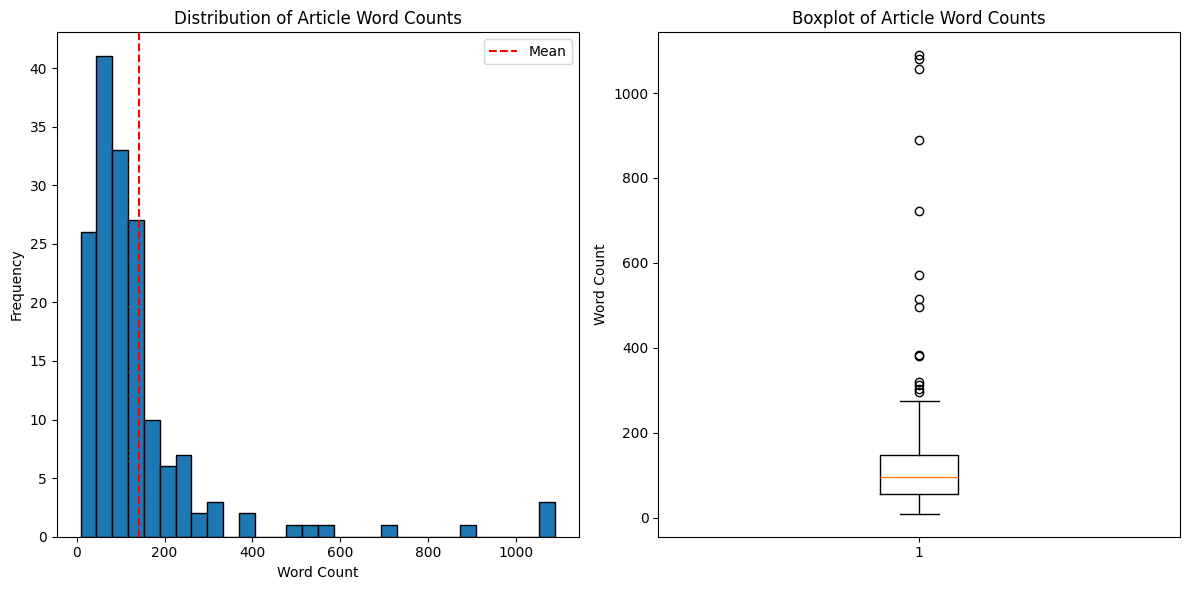

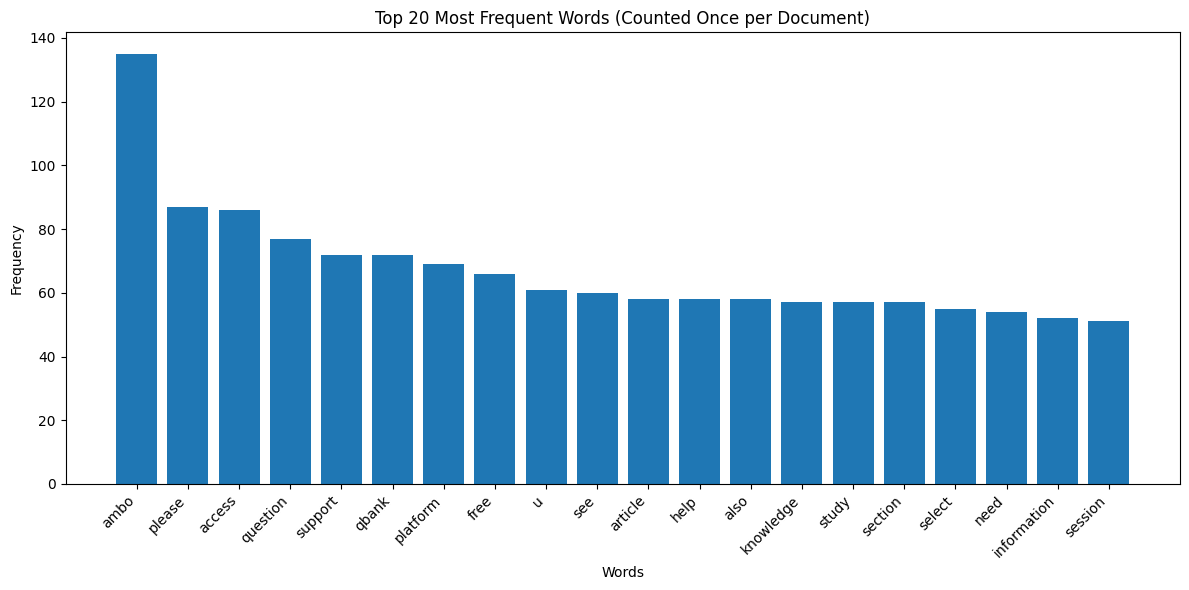

In [57]:
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.pyplot as plt

average_body_length = df['body_cleaned'].str.len().mean()
body_word_count = df['body_cleaned'].str.split().apply(len)

# histogram for word count distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(body_word_count, bins=30, edgecolor='black')
plt.title("Distribution of Article Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.axvline(body_word_count.mean(), color='r', linestyle='--', label='Mean')
plt.legend()

# boxplot for word count distribution
plt.subplot(1, 2, 2)
plt.boxplot(body_word_count)
plt.title("Boxplot of Article Word Counts")
plt.ylabel("Word Count")

plt.tight_layout()
plt.show()

# get unique words for each document
document_words = df['body_cleaned'].apply(lambda x: set(x.split()))
all_unique_words = [word for doc_words in document_words for word in doc_words]
word_freq = Counter(all_unique_words)
most_common_words = word_freq.most_common(20)  

# plot top 20 words
plt.figure(figsize=(12, 6))
words, counts = zip(*most_common_words)
plt.bar(words, counts)
plt.title("Top 20 Most Frequent Words (Counted Once per Document)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()


## Data Analysis Insights

By looking at the graphs, we can draw the following conclusions:

1. **Word Count Distribution**
   - The average word count per article is around 150.
   - Most articles have a slightly lower word count than the average.
   - There are potential outliers with approximately 5 times more words than others.
   - This variation in article length is something to keep in mind for further analysis.

2. **Common Words**
   - There's only one word that is repeated in almost all articles: `ambo`.
   - This makes sense because the company name is `amboss`.
   - It's likely that the lemmatizer changes `amboss` to `ambo`.
   - To increase model accuracy, we should consider removing `ambo` from the articles.

3. **Preprocessing Enhancement**
   - As a final step in the preprocessing pipeline, it would be beneficial to add the title to the text.
   - This can provide useful additional context for the model.

### Next Steps

1. Remove `ambo` from the articles to improve model accuracy.
2. Incorporate the article title into the main text for each document.

In [58]:
df['body_cleaned'] = df['body_cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word != 'ambo']))
df['article_cleaned'] = 'Article title: ' + df['title'] + '. Article body: ' + df['body_cleaned']

## Data Processing and Vectorization

Now that the data is cleaned, we will process the cleaned articles using two types of vectorization:

1. TF-IDF (Term Frequency-Inverse Document Frequency) Vectorization
2. Count Vectorization

We are using both types of vectorization because:
- Different unsupervised models work better with different vectorization methods
- The choice depends on whether it's a probabilistic model (like LDA) or a matrix-based model

### Experimenting with N-gram Ranges

We'll experiment with different n-gram ranges for the TF-IDF vectorizer to observe:
- How it affects the number of features extracted from the text
- The types of features extracted from the text

This experimentation will help us understand the impact of including different combinations of words (unigrams, bigrams, etc.) on our feature representation.


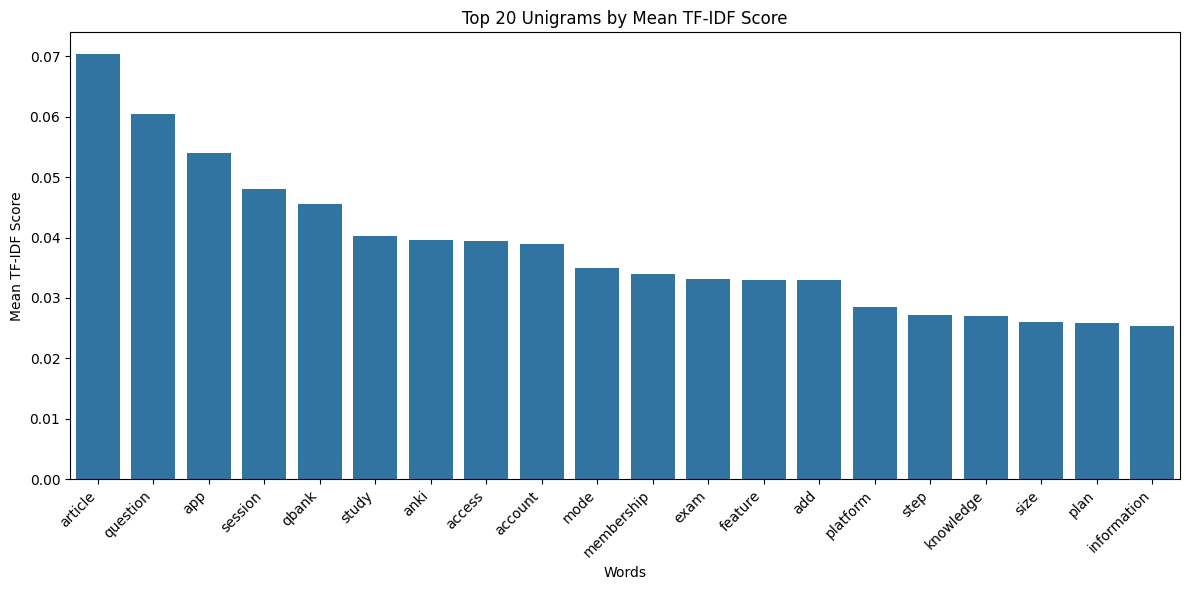

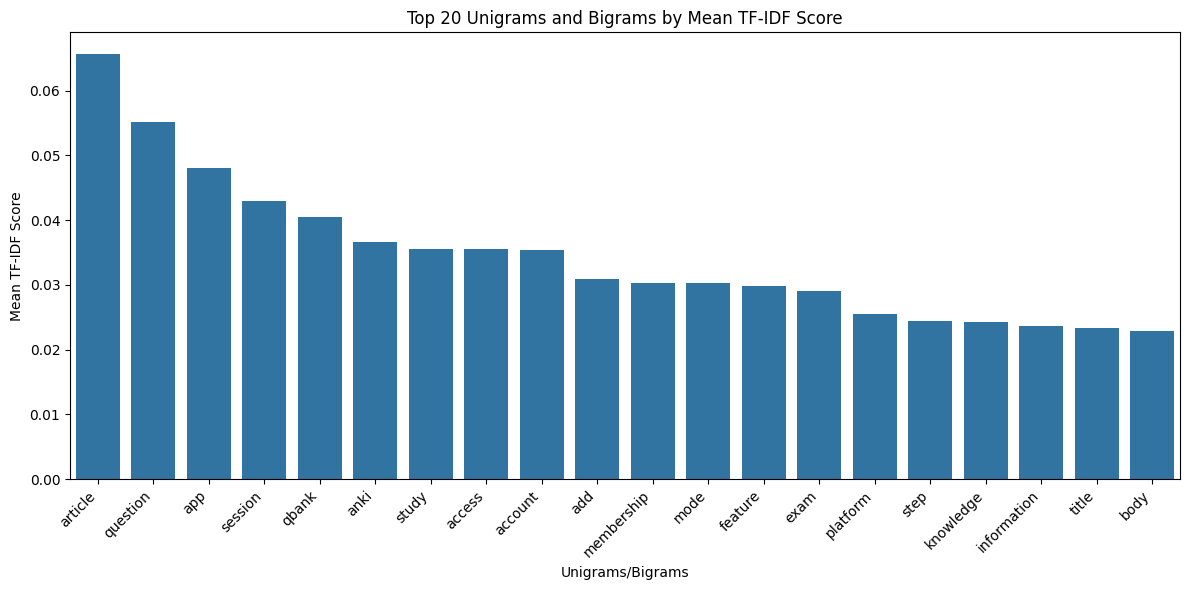

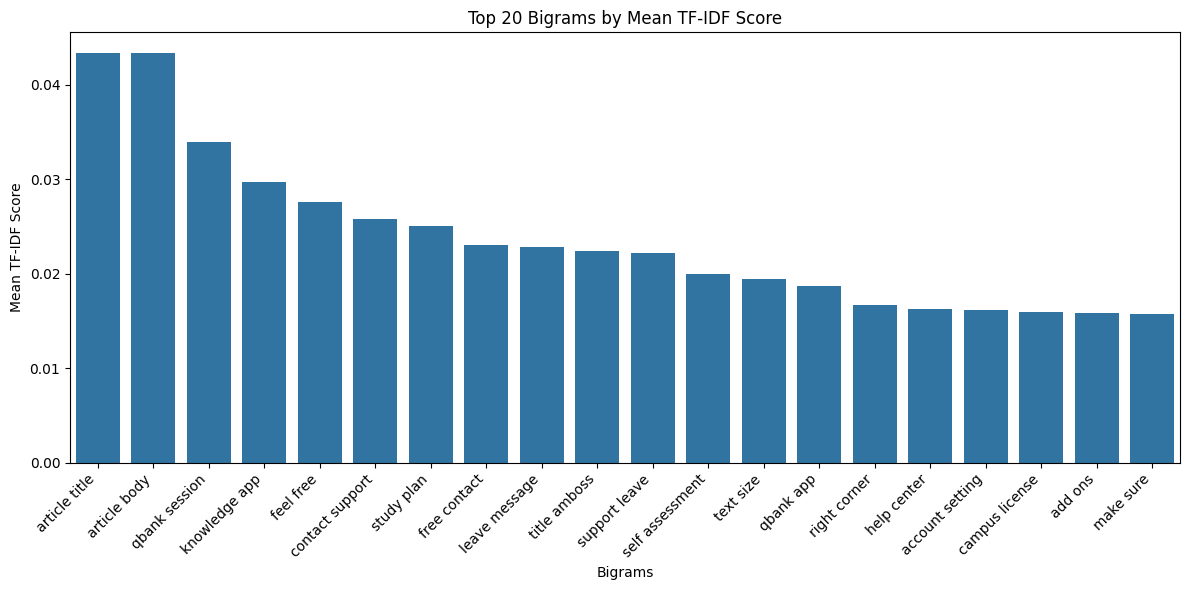

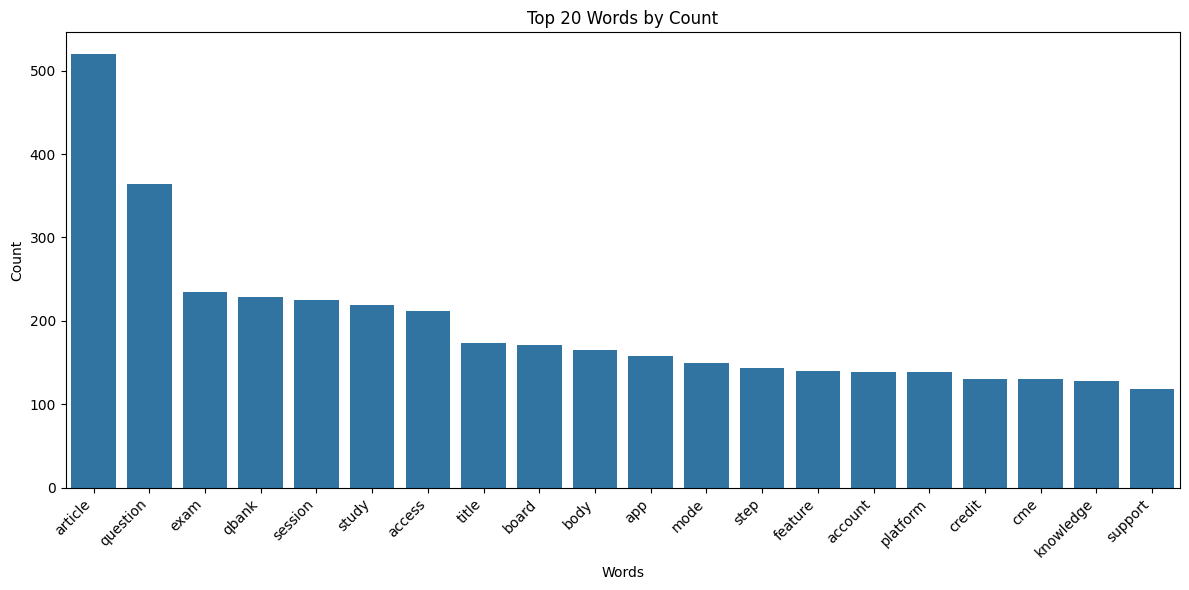

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns

# tf-idf score for each word
unigram_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english')
unigram_matrix = unigram_vectorizer.fit_transform(df['article_cleaned'])
unigram_feature_names = unigram_vectorizer.get_feature_names_out()
unigram_mean_tfidf_scores = unigram_matrix.mean(axis=0).A1

unigram_df = pd.DataFrame({'feature': unigram_feature_names, 'mean_tfidf': unigram_mean_tfidf_scores})
unigram_df = unigram_df.sort_values('mean_tfidf', ascending=False)

# plot top 20 unigrams by mean score
plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='mean_tfidf', data=unigram_df.head(20))
plt.title("Top 20 Unigrams by Mean TF-IDF Score")
plt.xlabel("Words")
plt.ylabel("Mean TF-IDF Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# tf-idf score for unigram-bigrams
uni_to_bigram_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(1, 2))
uni_to_bigram_matrix = uni_to_bigram_vectorizer.fit_transform(df['article_cleaned'])
uni_to_bigram_feature_names = uni_to_bigram_vectorizer.get_feature_names_out()
uni_to_bigram_mean_tfidf_scores = uni_to_bigram_matrix.mean(axis=0).A1


uni_to_bigram_df = pd.DataFrame({'feature': uni_to_bigram_feature_names, 'mean_tfidf': uni_to_bigram_mean_tfidf_scores})
uni_to_bigram_df = uni_to_bigram_df.sort_values('mean_tfidf', ascending=False)

# uni-biggram analysis
plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='mean_tfidf', data=uni_to_bigram_df.head(20))
plt.title("Top 20 Unigrams and Bigrams by Mean TF-IDF Score")
plt.xlabel("Unigrams/Bigrams")
plt.ylabel("Mean TF-IDF Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# tf-idf score for bigrams only
bigram_vectorizer = TfidfVectorizer(max_features=2000, stop_words='english', ngram_range=(2, 2))
bigram_matrix = bigram_vectorizer.fit_transform(df['article_cleaned'])
bigram_feature_names = bigram_vectorizer.get_feature_names_out()
bigram_mean_tfidf_scores = bigram_matrix.mean(axis=0).A1

bigram_df = pd.DataFrame({'feature': bigram_feature_names, 'mean_tfidf': bigram_mean_tfidf_scores})
bigram_df = bigram_df.sort_values('mean_tfidf', ascending=False)

# bigram analysis
plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='mean_tfidf', data=bigram_df.head(20))
plt.title("Top 20 Bigrams by Mean TF-IDF Score")
plt.xlabel("Bigrams")
plt.ylabel("Mean TF-IDF Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# count vector analysis
count_vectorizer = CountVectorizer(max_features=2000, stop_words='english')
count_matrix = count_vectorizer.fit_transform(df['article_cleaned'])
count_feature_names = count_vectorizer.get_feature_names_out()
count_scores = count_matrix.sum(axis=0).A1

count_df = pd.DataFrame({'feature': count_feature_names, 'count': count_scores})
count_df = count_df.sort_values('count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='feature', y='count', data=count_df.head(20))
plt.title("Top 20 Words by Count")
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





## Analysis of TF-IDF Graphs:

### Unigram Graph:
The unigram graph shows no stop words or irrelevant terms (such as "support") that might unnecessarily influence our unsupervised model. This suggests our initial preprocessing was effective.

### Unigram-Bigram Graph:
Interestingly, the unigram-bigram graph only displays unigrams, indicating that individual words have higher TF-IDF scores than word pairs in this context.

### Bigram-only Graph:
In the bigram-only analysis, we've identified several word pairs that, while common, may not contribute significantly to the meaning of the text. These could potentially be removed to focus on more informative features:
* "free contact"
* "leave message"
* "support leave"
* "right corner"
* "contact support"

We'll remove these bigrams to help refine our feature set for the unsupervised model, ensuring we focus on the most meaningful content.

In [60]:
bigrams_to_remove = [
    "free contact",
    "leave message",
    "support leave",
    "right corner",
    "contact support"
]

def remove_bigrams(text, bigrams):
    for bigram in bigrams:
        text = text.replace(bigram, "")
    return text

df['article_cleaned'] = df['article_cleaned'].apply(lambda x: remove_bigrams(x, bigrams_to_remove))

We've finished our EDA and preprocessing our data so that it can be handled well by our unsupervised model.

# Step 4 

## Model choosing

Since we don't have labelled data, we will need to use unsupervised algorithms for this topic modelling task. According to online research ([source](https://hpi.de/naumann/teaching/current-courses/ss-16/advanced-topic-modeling.html)), LDA (latent Dirichlet allocation) is the most common model used and NMF is also a potential model used to compare the models. The difficulty in this machine learning problem is how will the model handle new topics that are created that aren't seen in the dataset. 

### Choosing the vectorizers 

Each model works best with a different vectorizer. LDA is a probabilistic model that assumes each topic has a distribution over words - and it works best with word counts as it models the probability of words appearing in topics. ([source](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)). 

NMF on the otherhand is not a probability model, and it works by finding two non-negative matrices whose product approximates the original document-term matrix. TF-IDF works best because it reduces the impact of document length by normalizing term frequency and downwighing common words that appear across documents - thus improving the NMF model ability to identity meaningful latent factors and topics. 

We will do a first pass using the LDA model then we will do the same with the NMF model - the evaluation will include tuning the hyperparameters to increase the accuracy of the models.

### Evaluation

For LDA, we will use perplexity and log-likelihood to evaluate whether the model fits the data will and will predict future and unknown knowledge base articles well. Perplexity is defined as "Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before" (source)[https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0]. A high log-likelihood score means the model is better at explaining the observed data and the lower the perplexity score the less suprised a model is of new data it has not seen before. 




Best model based on perplexity: n_components = 32


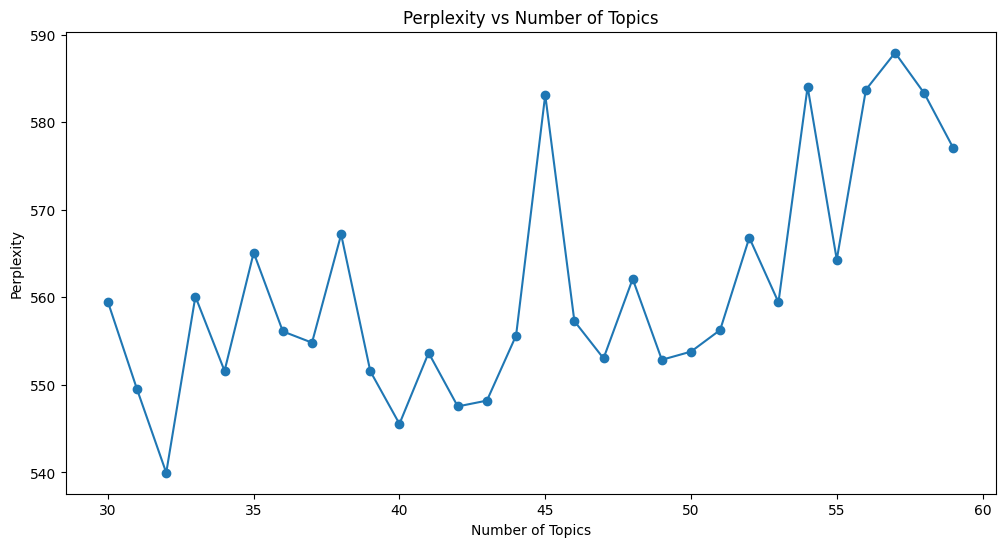

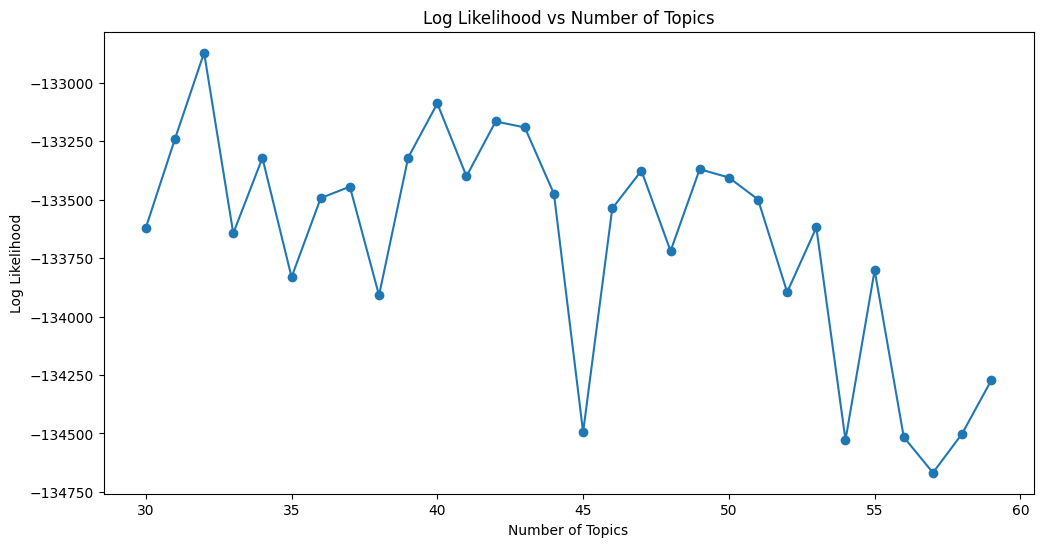


Top words for each topic using the best model:
Topic 1: exam, score, passing, likelihood, target, date, pas, 100, 99, predicted
Topic 2: app, access, article, knowledge, high, yield, offline, refresh, switch, website
Topic 3: condition, management, step, checklist, disease, task, article, feel, search, provide
Topic 4: article, size, text, app, qbank, body, title, right, apps, mobile
Topic 5: mobile, support, explanation, anki, pop, add, beta, card, notification, enable
Topic 6: password, assessment, self, score, receive, check, report, link, reset, exam
Topic 7: article, feature, information, study, key, exam, content, session, question, info
Topic 8: browser, version, issue, message, update, article, contact, latest, try, leave
Topic 9: article, information, app, drug, button, feature, payment, knowledge, access, section
Topic 10: privacy, page, option, service, physician, data, policy, article, amboss, use
Topic 11: step, article, study, feature, library, access, exam, ck, usmle, q

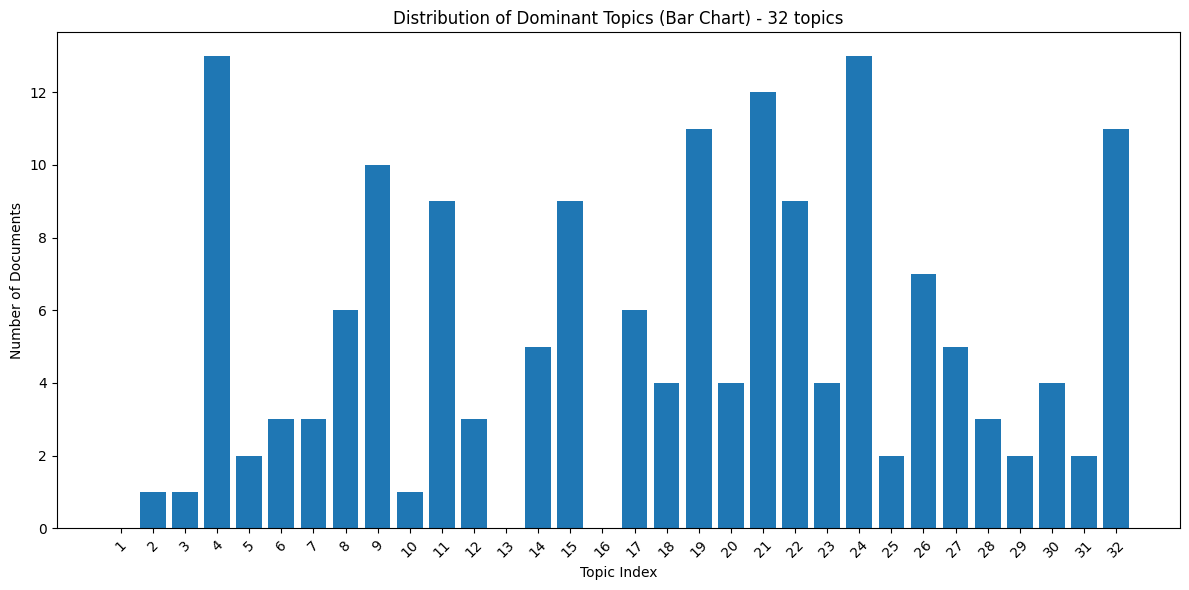

In [61]:


n_components_values = range(30,60)
results = []

# save the perplexity and log likelihood for each model
for n in n_components_values:
    lda_model = LatentDirichletAllocation(n_components=n, random_state=42)
    lda_output = lda_model.fit_transform(count_matrix)
    
    perplexity = lda_model.perplexity(count_matrix)
    log_likelihood = lda_model.score(count_matrix)
    
    results.append({
        'n_components': n,
        'perplexity': perplexity,
        'log_likelihood': log_likelihood
    })
    

# use perplexity to find the best model
best_model = min(results, key=lambda x: x['perplexity'])
print(f"\nBest model based on perplexity: n_components = {best_model['n_components']}")

# plot of perplexity
plt.figure(figsize=(12, 6))
plt.plot(n_components_values, [r['perplexity'] for r in results], marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Perplexity vs Number of Topics')
plt.show()

# plot of log likelihood
plt.figure(figsize=(12, 6))
plt.plot(n_components_values, [r['log_likelihood'] for r in results], marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood vs Number of Topics')
plt.show()

# Use the best model to display top words for each topic
best_lda_model = LatentDirichletAllocation(n_components=best_model['n_components'], random_state=42)
best_lda_output = best_lda_model.fit_transform(count_matrix)

print("\nTop words for each topic using the best model:")
words = count_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(best_lda_model.components_):
    top_words_idx = topic.argsort()[:-10 - 1:-1]
    top_words = [words[i] for i in top_words_idx]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")


df['dominant_topic_index'] = best_lda_output.argmax(axis=1) + 1 # start index from 1
topic_counts = df['dominant_topic_index'].value_counts().sort_index()

# add 0 for missing topics
for i in range(1, best_model['n_components'] + 1):
    if i not in topic_counts.index:
        topic_counts[i] = 0

plt.figure(figsize=(12, 6))
plt.bar(topic_counts.index, topic_counts.values)
plt.xlabel('Topic Index')
plt.ylabel('Number of Documents')
plt.title(f'Distribution of Dominant Topics (Bar Chart) - {best_model["n_components"]} topics')
plt.xticks(range(1, len(topic_counts) + 1), rotation=45)
plt.tight_layout()
plt.show()



### Analysis of LDA results

By taking a look at the Distubtion of Dominant Topics, we can see that no topic is dominant and the distribution is normal. There are 165 documents, and the topic with high document count is topic 4 with 12 documents - which means that the model is able to predict distinct themes in the documents. Also the perplexity score with n_components = 32 is 540. While a lower perpleity score is generally better, it's not a perfect predictor. I will manually look at a few samples after finishing the NMF model to compare
